## Name: Margaret Nguyen

# Exploring the Impact of Infrastructure on Incident Rates for Vulnerable Road Users: A Machine Learning Analysis

**Assignment: Use the 'POPULATION' variable to conduct stepwise regression. This coding file is intended for the dataset without BNA score.**

In [144]:
# Import packages
import numpy as np # v 1.21.5
import sklearn # v 1.0.2
import pandas as pd # v 1.4.4
import ydata_profiling as pp # v 3.6.6
import statsmodels.api as sm # v 0.13.2
from mlxtend.feature_selection import SequentialFeatureSelector # v 0.23.0

# Regression
from sklearn.linear_model import LinearRegression # v 1.0.2
from sklearn.model_selection import train_test_split # v 1.0.2

# PCA
from sklearn.decomposition import PCA # v 1.0.2
from sklearn.preprocessing import StandardScaler # v 1.0.2

from sklearn.metrics import mean_absolute_error # v 1.0.2
from sklearn.metrics import mean_squared_error # v 1.0.2
from sklearn.metrics import mean_absolute_percentage_error # v 1.0.2

# Ploting libraries 
import matplotlib
#matplotlib.use('Qt5Agg')  # Use an appropriate backend like 'Qt5Agg' for GUI display
import matplotlib.pyplot as plt # v 3.5.2
import seaborn as sns # v 0.11.2
# Display any generated plots or visualizations directly in the notebook interface
%matplotlib inline 

# I. Data Manipulation

In [145]:
# Read the csv file 
df_pa_acs = pd.read_csv('/Users/margaret06/Documents/GitHub/Carlisle_Borough_Transportation_Study/data/2017_TO_2021_MUNI_CRASH_DATA.csv')

df_mass_acs = pd.read_csv('/Users/margaret06/Documents/GitHub/Carlisle_Borough_Transportation_Study/data/df_mass_acs.csv', low_memory=False)

df_col_acs = pd.read_csv('/Users/margaret06/Documents/GitHub/Carlisle_Borough_Transportation_Study/data/df_col_acs.csv')

## A. Clean the Pennsylvania Crash Dataset

In [146]:
# Clean datasets
df_pa_acs.drop(columns = ['Unnamed: 0'], inplace=True)

# Select columns with numeric data types (int or float) using select_dtypes
numeric_columns = df_pa_acs.select_dtypes(include=['number'])

# Create a new DataFrame with only the numeric columns
df_pa_crash = df_pa_acs[numeric_columns.columns]

# Drop unnessary columns
df_pa_crash = df_pa_crash.drop(['PENN_DOT_MUNI_ID', 'state', 'county', 'county_subdivision', 'LAND_AREA.1', 'LAND_AREA', 'PENN_DOT_COUNTY_NUM', 'FEDERAL_EIN_CODE', 'HOME_RULE_YEAR', 'INCORPORATION_YEAR', 'MUNICIPALITY'], axis=1)

# Replace NaN values with 0 throughout the DataFrame to address missing data, following the experience of cleaning the original dataset.
df_pa_crash = df_pa_crash.fillna(0)

# Drop population == 0 (small municipalities)
df_pa_crash = df_pa_crash[df_pa_crash['POPULATION'] != 0]

# Reset index
df_pa_crash.reset_index(inplace = True, drop = True)

In [147]:
# Define the columns for which you want to calculate per capita values
columns_to_convert = [
    'BIKE_TO_WORK_EST', 'BIKE_TO_WORK_MARG',
    'WALK_TO_WORK_EST', 'WALK_TO_WORK_MARG', 'DRIVE_SOLO_TO_WORK_EST',
    'DRIVE_SOLO_TO_WORK_MARG', 'CARPOOL_TO_WORK_EST',
    'CARPOOL_TO_WORK_MARG', 'PUBTRANS_TO_WORK_EST',
    'PUBTRANS_TO_WORK_MARG', 'EMPLOYEES_FULL_TIME',
    'EMPLOYEES_PART_TIME', 'AUTOMOBILE_COUNT',
    'BICYCLE_BY_AUTO_COUNT', 'BICYCLE_DEATH_BY_AUTO_COUNT',
    'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 'PED_BY_AUTO_COUNT',
    'PED_DEATH_BY_AUTO_COUNT', 'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT',
    'BICYCLE_SOLO_COUNT', 'BICYCLE_DEATH_SOLO_COUNT',
    'BICYCLE_SUSP_SERIOUS_INJ_SOLO_COUNT', 'PED_SOLO_COUNT',
    'PED_DEATH_SOLO_COUNT', 'PED_SUSP_SERIOUS_INJ_SOLO_COUNT',
]

# Create new columns with "_PER_CAPITA" suffix by dividing each column by 'POPULATION'
for column in columns_to_convert:
    new_column_name = column + '_PER_CAPITA'
    df_pa_crash[new_column_name] = df_pa_crash[column] / df_pa_crash['POPULATION']

## B. Clean the Massachusett Crash Dataset

In [148]:
# Clean datasets
df_mass_acs.drop(columns = ['Unnamed: 0'], inplace=True)

# Exclude the NaN from 'VEHC_CONFIG_CL'
df_mass_crash = df_mass_acs[df_mass_acs['VEHC_CONFIG_CL'].notna()]

# List of NOT automobiles: Snowmobile, Moped, Motorcycle, Other Light Trucks (10,000 lbs., or Less), Other e.g. Farm Equipment, Unknown.
# Exclude the non-automobiles from 'VEHC_CONFIG_CL' columns
list_non_automobiles = ['V1:(Unknown vehicle configuration)', 'V1:(Other e.g. farm equipment)', 'V1:(Unknown vehicle configuration) / V2:(Unknown vehicle configuration)']
df_mass_crash= df_mass_crash[~df_mass_crash['VEHC_CONFIG_CL'].isin(list_non_automobiles)]

In [149]:
# Fatal - injuries that resulted in death 
# Incapacitating - serious injuries require immediate medical attention

## BICYCLE_DEATH_BY_AUTO_COUNT
# Filter the DataFrame for cyclist fatalities
cyclist_fatalities = df_mass_crash[(df_mass_crash['INJY_STAT_DESCR'] == 'Fatal injury (K)') & (df_mass_crash['NON_MTRST_TYPE_CL'] == 'Cyclist')]

# Group the filtered DataFrame by 'CITY_TOWN_NAME' and calculate the count for each city
bicycle_death_counts = cyclist_fatalities.groupby('CITY_TOWN_NAME').size().reset_index(name='BICYCLE_DEATH_BY_AUTO_COUNT')

# Merge the bicycle_death_counts DataFrame into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(bicycle_death_counts, on='CITY_TOWN_NAME', how='left')

## BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT
cyclist_incapacitating = df_mass_crash[(df_mass_crash['INJY_STAT_DESCR'] == 'Non-fatal injury - Incapacitating') & (df_mass_crash['NON_MTRST_TYPE_CL'] == 'Cyclist')]
bicycle_sus_serious_inj_counts = cyclist_incapacitating.groupby('CITY_TOWN_NAME').size().reset_index(name='BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT')

# Merge the bicycle_sus_serious_inj_counts DataFrame into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(bicycle_sus_serious_inj_counts, on='CITY_TOWN_NAME', how='left')

# Replace NaN values with 0 in the specified columns
df_mass_crash['BICYCLE_DEATH_BY_AUTO_COUNT'].fillna(0, inplace=True)
df_mass_crash['BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT'].fillna(0, inplace=True)

## BICYCLE_BY_AUTO_COUNT
df_mass_crash['BICYCLE_BY_AUTO_COUNT'] = df_mass_crash['BICYCLE_DEATH_BY_AUTO_COUNT'] + df_mass_crash['BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT']

## AUTOMOBILE_COUNT
auto_count = df_mass_crash.groupby('CITY_TOWN_NAME')['NUMB_VEHC'].sum().reset_index()
auto_count.rename(columns={'NUMB_VEHC': 'AUTOMOBILE_COUNT'}, inplace=True)
# Merge the auto_count into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(auto_count, on='CITY_TOWN_NAME', how='left')

## PED_DEATH_BY_AUTO_COUNT
# Filter the DataFrame for pedestrian fatalities
ped_fatalities = df_mass_crash[(df_mass_crash['INJY_STAT_DESCR'] == 'Fatal injury (K)') & (df_mass_crash['NON_MTRST_TYPE_CL'] == 'Pedestrian')]

# Group the filtered DataFrame by 'CITY_TOWN_NAME' and calculate the count for each city
ped_death_counts = cyclist_fatalities.groupby('CITY_TOWN_NAME').size().reset_index(name='PED_DEATH_BY_AUTO_COUNT')

# Merge the ped_death_counts DataFrame into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(ped_death_counts, on='CITY_TOWN_NAME', how='left')

## PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT
ped_incapacitating = df_mass_crash[(df_mass_crash['INJY_STAT_DESCR'] == 'Non-fatal injury - Incapacitating') & (df_mass_crash['NON_MTRST_TYPE_CL'] == 'Pedestrian')]
ped_sus_serious_inj_counts = ped_incapacitating.groupby('CITY_TOWN_NAME').size().reset_index(name='PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT')

# Merge the ped_sus_serious_inj_counts DataFrame into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(ped_sus_serious_inj_counts, on='CITY_TOWN_NAME', how='left')

# Replace NaN values with 0 in the specified columns
df_mass_crash['PED_DEATH_BY_AUTO_COUNT'].fillna(0, inplace=True)
df_mass_crash['PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT'].fillna(0, inplace=True)

##PED_BY_AUTO_COUNT
df_mass_crash['PED_BY_AUTO_COUNT'] = df_mass_crash['PED_DEATH_BY_AUTO_COUNT'] + df_mass_crash['PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT']

# Drop the duplicated rows
df_mass_crash = df_mass_crash.drop_duplicates(subset=['CITY_TOWN_NAME', 'POPULATION', 
                                                      'BIKE_TO_WORK_EST', 'BICYCLE_BY_AUTO_COUNT', 
                                                      'BICYCLE_DEATH_BY_AUTO_COUNT', 
                                                      'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 
                                                      'AUTOMOBILE_COUNT', 'PED_BY_AUTO_COUNT', 
                                                      'PED_DEATH_BY_AUTO_COUNT', 'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT'])

In [150]:
# Select columns with numeric data types (int or float) using select_dtypes
numeric_columns = df_mass_crash.select_dtypes(include=['number'])

# Create a new DataFrame with only the numeric columns
df_mass_crash = df_mass_crash[numeric_columns.columns]

# Reset index
df_mass_crash.reset_index(drop = True, inplace = True)

In [151]:
# Define the columns for which you want to calculate per capita values
columns_to_convert = [
    'BIKE_TO_WORK_EST', 'BIKE_TO_WORK_MARG',
    'WALK_TO_WORK_EST', 'WALK_TO_WORK_MARG', 'DRIVE_SOLO_TO_WORK_EST',
    'DRIVE_SOLO_TO_WORK_MARG', 'CARPOOL_TO_WORK_EST',
    'CARPOOL_TO_WORK_MARG', 'PUBTRANS_TO_WORK_EST',
    'PUBTRANS_TO_WORK_MARG', 'AUTOMOBILE_COUNT',
    'BICYCLE_BY_AUTO_COUNT', 'BICYCLE_DEATH_BY_AUTO_COUNT',
    'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 'PED_BY_AUTO_COUNT',
    'PED_DEATH_BY_AUTO_COUNT', 'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT']

# Create new columns with "_PER_CAPITA" suffix by dividing each column by 'POPULATION'
for column in columns_to_convert:
    new_column_name = column + '_PER_CAPITA'
    df_mass_crash[new_column_name] = df_mass_crash[column] / df_mass_crash['POPULATION']

## C. Clean the Colorado Crash Dataset

In [152]:
# Clean datasets
df_col_acs.drop(columns = ['Unnamed: 0'], inplace=True)

In [153]:
# Nake a copy of df_col_acs
df_col_crash = df_col_acs.copy()

In [154]:
# Define the columns for which you want to calculate per capita values
columns_to_convert = [
    'BIKE_TO_WORK_EST', 'BIKE_TO_WORK_MARG',
    'WALK_TO_WORK_EST', 'WALK_TO_WORK_MARG', 'DRIVE_SOLO_TO_WORK_EST',
    'DRIVE_SOLO_TO_WORK_MARG', 'CARPOOL_TO_WORK_EST',
    'CARPOOL_TO_WORK_MARG', 'PUBTRANS_TO_WORK_EST',
    'PUBTRANS_TO_WORK_MARG', 
    'BICYCLE_BY_AUTO_COUNT', 'BICYCLE_DEATH_BY_AUTO_COUNT',
    'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 'PED_BY_AUTO_COUNT',
    'PED_DEATH_BY_AUTO_COUNT', 'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT']

# Create new columns with "_PER_CAPITA" suffix by dividing each column by 'POPULATION'
for column in columns_to_convert:
    new_column_name = column + '_PER_CAPITA'
    df_col_crash[new_column_name] = df_col_crash[column] / df_col_crash['POPULATION']

In [155]:
# Set the STATE coloumn
df_pa_crash['STATE'] = 'PA'
df_mass_crash['STATE'] = 'MA'
df_col_crash['STATE'] = 'CO'

In [156]:
# Find the common columns
common_columns = list(set(df_pa_crash.columns) & set(df_col_crash.columns) & set(df_mass_crash.columns))

# Keep to have the same columns
df_mass_crash = df_mass_crash[common_columns]
df_pa_crash = df_pa_crash[common_columns]
df_col_crash = df_col_crash[common_columns]

# Reorder the columns of the df_mass_crash and df_col_crash to match df_pa_crash
df_mass_crash = df_mass_crash[df_pa_crash.columns]
df_col_crash = df_col_crash[df_pa_crash.columns]

In [157]:
# Print the shape of each datadrame
df_mass_crash.shape, df_pa_crash.shape, df_col_crash.shape

((293, 34), (2565, 34), (127, 34))

## C. Merge df_pa_crash and df_mass_crash Dataframes

In [158]:
# Merge dataframes
crash_acs = pd.concat([df_pa_crash, df_mass_crash], axis=0)
df_crash_acs = pd.concat([crash_acs, df_col_crash], axis=0)

# Reset index
df_crash_acs.reset_index(drop = True, inplace = True)

# Check for the shape of the datafrane
print(df_crash_acs.shape)

# Show merge dataframe
df_crash_acs.head()

(2985, 34)


,PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT,CARPOOL_TO_WORK_MARG_PER_CAPITA,PUBTRANS_TO_WORK_MARG,BICYCLE_DEATH_BY_AUTO_COUNT,PED_DEATH_BY_AUTO_COUNT,BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT,PED_BY_AUTO_COUNT_PER_CAPITA,BIKE_TO_WORK_EST,PED_DEATH_BY_AUTO_COUNT_PER_CAPITA,BIKE_TO_WORK_MARG,...,BICYCLE_BY_AUTO_COUNT_PER_CAPITA,PUBTRANS_TO_WORK_EST_PER_CAPITA,PUBTRANS_TO_WORK_EST,BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA,BIKE_TO_WORK_EST_PER_CAPITA,STATE,PUBTRANS_TO_WORK_MARG_PER_CAPITA,POPULATION,BIKE_TO_WORK_MARG_PER_CAPITA,PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA
0,214.0,0.001954,4179,8.0,82.0,31.0,0.001633,14172,0.000051,940,...,0.000364,0.095223,152058,0.000019,0.008875,PA,0.002617,1596865,0.000589,0.000134
1,75.0,0.002685,1252,1.0,6.0,4.0,0.001778,1920,0.000020,290,...,0.000274,0.077033,23357,0.000013,0.006332,PA,0.004129,303207,0.000956,0.000247
2,3.0,0.004114,392,0.0,0.0,2.0,0.001165,729,0.000000,297,...,0.000347,0.044930,1813,0.000050,0.018066,PA,0.009715,40352,0.007360,0.000074
3,10.0,0.006992,312,1.0,3.0,5.0,0.001047,329,0.000031,191,...,0.000481,0.015512,1482,0.000052,0.003444,PA,0.003266,95536,0.001999,0.000105
4,0.0,0.017467,211,0.0,0.0,2.0,0.000208,259,0.000000,116,...,0.000260,0.030724,591,0.000104,0.013464,PA,0.010969,19236,0.006030,0.000000


**Create dumnmy variable for each dataframe**

In [159]:
df_crash_acs = pd.get_dummies(df_crash_acs, columns=['STATE'])

In [160]:
# Check for NaN missing values
df_crash_acs.isna().sum()

PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT                   0
CARPOOL_TO_WORK_MARG_PER_CAPITA                      0
PUBTRANS_TO_WORK_MARG                                0
BICYCLE_DEATH_BY_AUTO_COUNT                          0
PED_DEATH_BY_AUTO_COUNT                              0
BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT               0
PED_BY_AUTO_COUNT_PER_CAPITA                         0
BIKE_TO_WORK_EST                                     0
PED_DEATH_BY_AUTO_COUNT_PER_CAPITA                   0
BIKE_TO_WORK_MARG                                    0
DRIVE_SOLO_TO_WORK_EST                               0
DRIVE_SOLO_TO_WORK_MARG_PER_CAPITA                   0
PED_BY_AUTO_COUNT                                    0
WALK_TO_WORK_EST                                     0
BICYCLE_DEATH_BY_AUTO_COUNT_PER_CAPITA               0
DRIVE_SOLO_TO_WORK_MARG                              0
WALK_TO_WORK_MARG                                    0
BICYCLE_BY_AUTO_COUNT                                0
WALK_TO_WO

**Use Pandas Profiling**

In [161]:
#pp.ProfileReport(df_crash_acs)

In [162]:
# Assuming df_crash_acs is your DataFrame
selected_columns = [
    'CARPOOL_TO_WORK_MARG_PER_CAPITA', 
    'PED_BY_AUTO_COUNT_PER_CAPITA', 
    'PED_DEATH_BY_AUTO_COUNT_PER_CAPITA', 
    'DRIVE_SOLO_TO_WORK_MARG_PER_CAPITA', 
    'BICYCLE_DEATH_BY_AUTO_COUNT_PER_CAPITA', 
    'WALK_TO_WORK_MARG_PER_CAPITA', 
    'WALK_TO_WORK_EST_PER_CAPITA', 
    'CARPOOL_TO_WORK_EST_PER_CAPITA', 
    'DRIVE_SOLO_TO_WORK_EST_PER_CAPITA', 
    'BICYCLE_BY_AUTO_COUNT_PER_CAPITA', 
    'PUBTRANS_TO_WORK_EST_PER_CAPITA', 
    'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA', 
    'BIKE_TO_WORK_EST_PER_CAPITA', 
    'PUBTRANS_TO_WORK_MARG_PER_CAPITA', 
    'BIKE_TO_WORK_MARG_PER_CAPITA', 
    'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA', 
    'STATE_CO', 
    'STATE_MA',
    'STATE_PA'
]

# Select the specified columns from the DataFrame
df_crash_acs = df_crash_acs[selected_columns]

# II. Stepwise Regression

## A. Separate Dataset in Y (independent) and X (dependent) Variables

In [163]:
y = df_crash_acs["BICYCLE_BY_AUTO_COUNT_PER_CAPITA"] # Y = df_crash.BICYCLE_BY_AUTO_COUNT_PER_CAPITA
X = df_crash_acs.drop(columns="BICYCLE_BY_AUTO_COUNT_PER_CAPITA")

In [164]:
y2 = df_crash_acs["PED_BY_AUTO_COUNT_PER_CAPITA"] # Y = df_crash.PED_BY_AUTO_COUNT_PER_CAPITA
X2 = df_crash_acs.drop(columns="PED_BY_AUTO_COUNT_PER_CAPITA")

## B. Use the train_test_split Function to Split Data into Training (80%) and Testing Set (20%)

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [166]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=5)

## C. Fit, Run or Estimate the Regression Model

### 1. BICYCLE_BY_AUTO_COUNT_PER_CAPITA as the Dependent Variable

In [167]:
# Create a linear regression model
OLS = LinearRegression()

# Forward feature selection using SequentialFeatureSelector
sfs = SequentialFeatureSelector(OLS, k_features="best", forward=True, scoring='neg_mean_squared_error', cv=10)
sfs.fit(X_train, y_train)

# Selected features
selected_features = list(X_train.columns[list(sfs.k_feature_idx_)])
print("Selected Features:", selected_features)

Selected Features: ['PED_BY_AUTO_COUNT_PER_CAPITA', 'PED_DEATH_BY_AUTO_COUNT_PER_CAPITA', 'BICYCLE_DEATH_BY_AUTO_COUNT_PER_CAPITA', 'WALK_TO_WORK_EST_PER_CAPITA', 'CARPOOL_TO_WORK_EST_PER_CAPITA', 'DRIVE_SOLO_TO_WORK_EST_PER_CAPITA', 'PUBTRANS_TO_WORK_EST_PER_CAPITA', 'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA', 'BIKE_TO_WORK_EST_PER_CAPITA', 'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA', 'STATE_PA']


In [168]:
# Get the selected features
selected_features = list(X_train.columns[list(sfs.k_feature_idx_)])

# Build a linear regression model using statsmodels with the selected features
X_train_selected = X_train[selected_features]
X_train_selected = sm.add_constant(X_train_selected)  # Add a constant for the intercept
model = sm.OLS(y_train, X_train_selected).fit()

# Display the summary of the statsmodels linear regression model
print(model.summary())

                                   OLS Regression Results                                   
Dep. Variable:     BICYCLE_BY_AUTO_COUNT_PER_CAPITA   R-squared:                       0.282
Model:                                          OLS   Adj. R-squared:                  0.279
Method:                               Least Squares   F-statistic:                     84.79
Date:                              Wed, 29 Nov 2023   Prob (F-statistic):          6.31e-162
Time:                                      14:07:33   Log-Likelihood:                 17604.
No. Observations:                              2388   AIC:                        -3.518e+04
Df Residuals:                                  2376   BIC:                        -3.512e+04
Df Model:                                        11                                         
Covariance Type:                          nonrobust                                         
                                                        coef    std er

In [169]:
# Make predictions on the test data
X_test_selected = X_test[selected_features]
X_test_selected = sm.add_constant(X_test_selected) # Add a constant term to the test data
y_pred = model.predict(X_test_selected)

### 2. PED_BY_AUTO_COUNT_PER_CAPITA as the Dependent Variable

In [170]:
# Create a linear regression model
OLS = LinearRegression()

# Forward feature selection using SequentialFeatureSelector
sfs = SequentialFeatureSelector(OLS, k_features="best", forward=True, scoring='neg_mean_squared_error', cv=10)
sfs.fit(X_train2, y_train2)

# Selected features
selected_features2 = list(X_train2.columns[list(sfs.k_feature_idx_)])
print("Selected Features:", selected_features2)

Selected Features: ['PED_DEATH_BY_AUTO_COUNT_PER_CAPITA', 'BICYCLE_DEATH_BY_AUTO_COUNT_PER_CAPITA', 'WALK_TO_WORK_MARG_PER_CAPITA', 'WALK_TO_WORK_EST_PER_CAPITA', 'CARPOOL_TO_WORK_EST_PER_CAPITA', 'DRIVE_SOLO_TO_WORK_EST_PER_CAPITA', 'BICYCLE_BY_AUTO_COUNT_PER_CAPITA', 'PUBTRANS_TO_WORK_EST_PER_CAPITA', 'BIKE_TO_WORK_EST_PER_CAPITA', 'PUBTRANS_TO_WORK_MARG_PER_CAPITA', 'BIKE_TO_WORK_MARG_PER_CAPITA', 'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA', 'STATE_CO', 'STATE_MA', 'STATE_PA']


In [171]:
# Get the selected features
selected_features2 = list(X_train2.columns[list(sfs.k_feature_idx_)])

# Build a linear regression model using statsmodels with the selected features
X_train_selected2 = X_train2[selected_features2]
X_train_selected2 = sm.add_constant(X_train_selected2)  # Add a constant for the intercept
model2 = sm.OLS(y_train2, X_train_selected2).fit()

# Display the summary of the statsmodels linear regression model
print(model2.summary())

                                 OLS Regression Results                                 
Dep. Variable:     PED_BY_AUTO_COUNT_PER_CAPITA   R-squared:                       0.376
Model:                                      OLS   Adj. R-squared:                  0.372
Method:                           Least Squares   F-statistic:                     102.1
Date:                          Wed, 29 Nov 2023   Prob (F-statistic):          1.30e-230
Time:                                  14:07:38   Log-Likelihood:                 15757.
No. Observations:                          2388   AIC:                        -3.148e+04
Df Residuals:                              2373   BIC:                        -3.140e+04
Df Model:                                    14                                         
Covariance Type:                      nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.9

In [172]:
# Make predictions on the test data
X_test_selected2 = X_test2[selected_features2]
X_test_selected2 = sm.add_constant(X_test_selected2) # Add a constant term to the test data
y_pred2 = model2.predict(X_test_selected2)

## D. Plot the Residuals

### Graph 1: The residuals for the model with 'BICYCLE_BY_AUTO_COUNT_PER_CAPITA' as the dependent variable

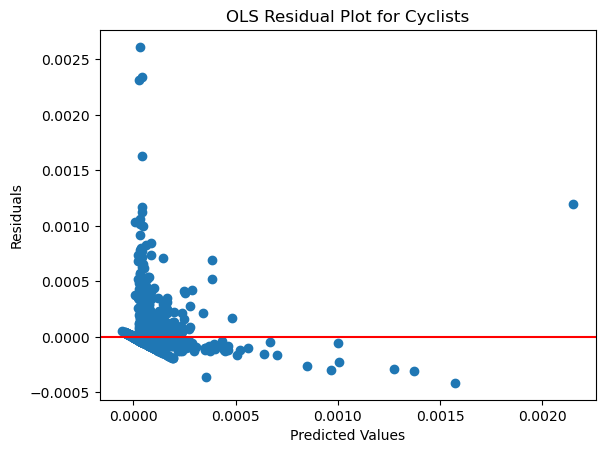

In [173]:
residuals = model.resid

plt.scatter(model.fittedvalues, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("OLS Residual Plot for Cyclists")
plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0
plt.show()

### Graph 2: The residuals for the model with 'PED_BY_AUTO_COUNT_PER_CAPITA' as the dependent variable

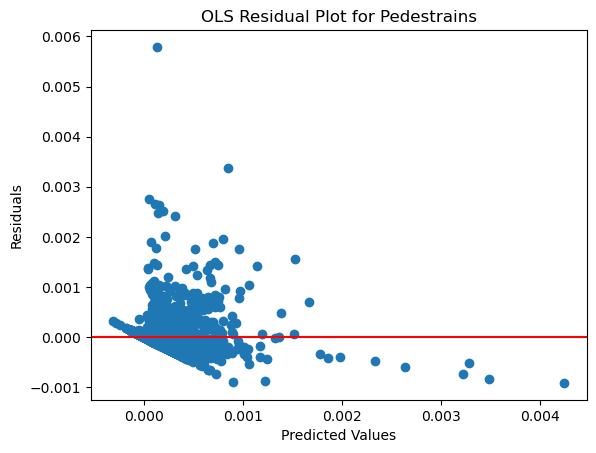

In [174]:
residuals2 = model2.resid

plt.scatter(model2.fittedvalues, residuals2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("OLS Residual Plot for Pedestrains")
plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0
plt.show()

## E. Plot the Actual vs. Predicted Values

### Graph 3: The Actual vs. Predicted Values for the model with 'BICYCLE_BY_AUTO_COUNT_PER_CAPITA' as the dependent variable

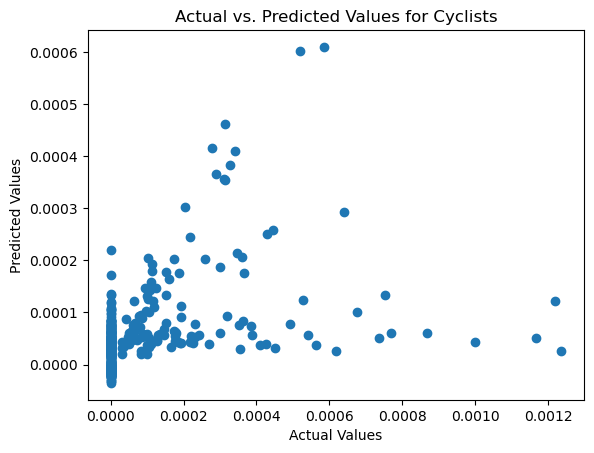

In [175]:
# Plot the actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values for Cyclists")
plt.show()

### Graph 4: The Actual vs. Predicted Values for the model with 'PED_BY_AUTO_COUNT_PER_CAPITA' as the dependent variable

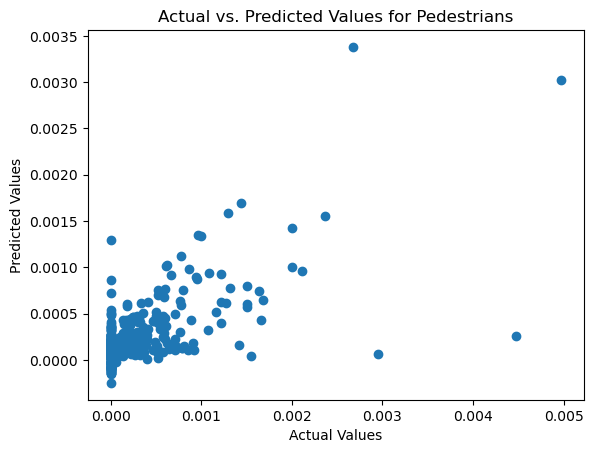

In [176]:
# Plot the actual vs. predicted values
plt.scatter(y_test2, y_pred2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values for Pedestrians")
plt.show()